In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


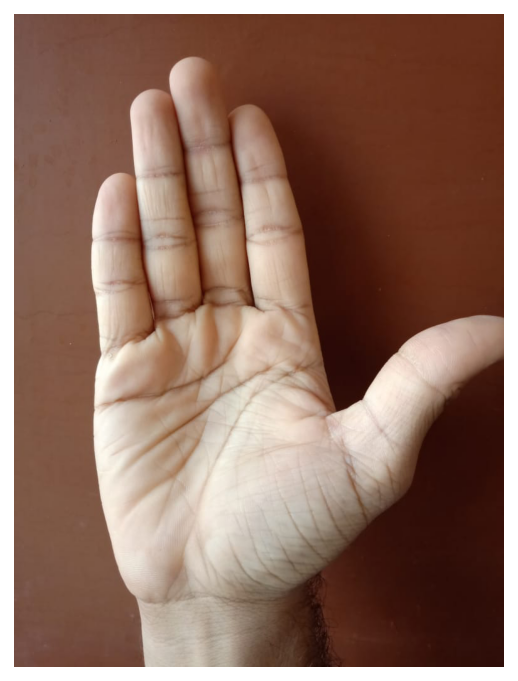

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import os
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd

img_dir = '/gdrive/My Drive/Gestures_Dataset'
test_dir = '/gdrive/My Drive/Test_Gestures'
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
# Example image
x = Image.open(img_dir + '/hand/handout (10).jpeg')
np.array(x).shape
imshow(x)

In [0]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(size=224),  # Image net standards
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


In [5]:
#Loading in the dataset

train_data = datasets.ImageFolder(img_dir,transform=train_transforms)
test_data = datasets.ImageFolder(test_dir,transform=test_transforms)
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2
# test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
num_test = len(test_data)
indices = list(range(num_train))
test_indices = list(range(num_test))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
# test_split = int(np.floor((valid_size+test_size) * num_train))
# valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]
valid_idx, train_idx = indices[:valid_split], indices[valid_split:]
test_idx = test_indices
print(len(valid_idx), len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, 
    sampler=test_sampler, num_workers=num_workers)

254 150 1018


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#pretrained=True will download a pretrained network for us
model = models.wide_resnet50_2(pretrained=True)

#Freezing model parameters and defining the fully connected network to be attached to the model, loss function and the optimizer.
#We there after put the model on the GPUs
for param in model.parameters():
  param.require_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048,5),nn.LogSoftmax(dim=1)
)
criterion = nn.NLLLoss()

#Over here we want to only update the parameters of the classifier so
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
model.to(device)

model

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/checkpoints/wide_resnet50_2-95faca4d.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [0]:
#Training the model and saving checkpoints of best performances. That is lower validation loss and higher accuracy
epochs = 15
valid_loss_min = np.Inf
import time
for epoch in range(epochs):
    
    start = time.time()
    
    #scheduler.step()
    model.train()
    
    train_loss = 0.0
    valid_loss = 0.0
    
    for inputs, labels in train_loader:
      
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
    train_loss += loss.item()
        
       
    model.eval()
    
    with torch.no_grad():
        accuracy = 0
        for inputs, labels in valid_loader:
            
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
        valid_loss += batch_loss.item()
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            
            
    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    valid_accuracy = accuracy/len(valid_loader) 
      
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
    epoch + 1, train_loss, valid_loss, valid_accuracy))
            
    
    
    if valid_loss <= valid_loss_min:
      
      
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      model_save_name = "Gestures_wideresnet50_2.pt"
      path = F"/gdrive/My Drive/Gestures_Dataset/{model_save_name}"
      torch.save(model.state_dict(), path)
      valid_loss_min = valid_loss        
      
    print(f"Time per epoch: {(time.time() - start):.3f} seconds")

Epoch: 1 	Training Loss: 0.007752 	Validation Loss: 0.099619 	Validation Accuracy: 0.091667
Validation loss decreased (inf --> 0.099619).  Saving model ...
Time per epoch: 2009.135 seconds
Epoch: 2 	Training Loss: 0.027696 	Validation Loss: 0.005914 	Validation Accuracy: 0.125000
Validation loss decreased (0.099619 --> 0.005914).  Saving model ...
Time per epoch: 1616.316 seconds
Epoch: 3 	Training Loss: 0.004641 	Validation Loss: 0.005205 	Validation Accuracy: 0.125000
Validation loss decreased (0.005914 --> 0.005205).  Saving model ...
Time per epoch: 1614.186 seconds
Epoch: 4 	Training Loss: 0.008236 	Validation Loss: 0.000871 	Validation Accuracy: 0.125000
Validation loss decreased (0.005205 --> 0.000871).  Saving model ...
Time per epoch: 1617.238 seconds
Epoch: 5 	Training Loss: 0.001044 	Validation Loss: 0.071369 	Validation Accuracy: 0.095833
Time per epoch: 1617.272 seconds


In [7]:
model.load_state_dict(torch.load('/gdrive/My Drive/Gestures_Dataset/Gestures_wideresnet50_2.pt'))

<All keys matched successfully>

In [8]:
def test(model, criterion):
# monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))
test(model, criterion)

Test Loss: 0.290323


Test Accuracy: 89% (134/150)
